# PS6: Let's Build a Multiple Asset Synthetic Data Generation System 
In this problem set, you will build a synthetic data generation system for multiple assets. The goal is to create a framework that allows you to simulate the price movements of various financial assets over time, taking into account correlations between them. 

> __Learning Objectives:__
> 
> By the end of this problem set, you should be able to:
> Three leaning objectives here

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We use daily open-high-low-close (OHLC) data for firms in the [S&P 500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2025` until `11-18-2025`, along with data for exchange-traded funds and volatility products.

Load the `original_dataset::DataFrame` by calling [the `MyTestingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTestingMarketDataSet).

In [2]:
original_dataset = MyTestingMarketDataSet() |> x-> x["dataset"] # load the original dataset (testing)

Dict{String, DataFrame} with 483 entries:
  "NI"   => 220×8 DataFrame…
  "EMR"  => 220×8 DataFrame…
  "CTAS" => 220×8 DataFrame…
  "HSIC" => 220×8 DataFrame…
  "KIM"  => 220×8 DataFrame…
  "PLD"  => 220×8 DataFrame…
  "IEX"  => 220×8 DataFrame…
  "BAC"  => 220×8 DataFrame…
  "CBOE" => 220×8 DataFrame…
  "EXR"  => 220×8 DataFrame…
  "NCLH" => 220×8 DataFrame…
  "CVS"  => 220×8 DataFrame…
  "DRI"  => 220×8 DataFrame…
  "DTE"  => 220×8 DataFrame…
  "ZION" => 220×8 DataFrame…
  "AVY"  => 220×8 DataFrame…
  "EW"   => 220×8 DataFrame…
  "EA"   => 220×8 DataFrame…
  "NWSA" => 220×8 DataFrame…
  ⋮      => ⋮

Not all tickers have the maximum number of trading days due to acquisition or delisting events. Collect only tickers with the maximum number of trading days.

Compute the number of records for `AAPL` and save that value in the `maximum_number_trading_days::Int64` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow # maximum number of trading days in our dataset

220

Iterate through the data and collect only tickers with `maximum_number_trading_days` records. Save the data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if ticker has maximum trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

Get a list of firms in the cleaned dataset and sort them alphabetically. Store the sorted ticker symbols in the `list_of_tickers_price_data::Array{String,1}` variable:

In [5]:
list_of_tickers_price_data = keys(dataset) |> collect |> sort; # list of tickers in our dataset

Next, let's load the HMM model that we estimated using historical data (2014 - 2024). First, we specify the `path_to_save_file::String` variable:

In [6]:
path_to_save_file = joinpath(_PATH_TO_DATA,"HMM-WJ-SPY-N-100-daily-aggregate.jld2");

Load the [`HDF5` binary file](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) using [the `load(...)` function from JLD2.jl](https://github.com/JuliaIO/JLD2.jl.git). This loads the saved data into the `saved_state_dict::Dict{String, Any}` variable.

In [7]:
saved_state_dict = load(path_to_save_file)

Dict{String, Any} with 11 entries:
  "risk_free_rate"          => 0.043
  "model"                   => MyHiddenMarkovModel([1, 2, 3, 4, 5, 6, 7, 8, 9, …
  "decode"                  => Dict{Int64, Normal}(5=>Normal{Float64}(μ=-3.3565…
  "encoded_archive_with_ju… => [53 72 … 82 92; 93 82 … 80 5; … ; 14 67 … 87 13;…
  "insampledataset"         => [-0.62754, 0.839626, 0.162992, -0.0111337, 0.257…
  "jump_model"              => MyHiddenMarkovModelWithJumps([1, 2, 3, 4, 5, 6, …
  "encoded_archive"         => [48 29 … 28 33; 42 10 … 10 68; … ; 18 37 … 39 77…
  "number_of_states"        => 100
  "in_sample_decoded_archi… => [0.202562 0.962389 … 1.56531 2.7557; 2.94573 1.6…
  "stationary"              => Categorical{Float64, Vector{Float64}}(…
  "in_sample_decoded_archi… => [0.0753184 -0.675607 … -0.759002 -0.470222; -0.1…

Finally, let's load the single index model parameters that we computed in the previous example. We'll store this data in the `sim_model_parameters::Dict{String,NamedTuple}` variable. In addition, we return a few other useful variables, such as the historical market growth rate, the mean and variance of the market growth, etc.

In [8]:
sim_model_parameters,Gₘ,Ḡₘ,Varₘ = let

    # initialize -
    path_to_sim_model_parameters = joinpath(_PATH_TO_DATA,"SIMs-SPY-SP500-01-03-14-to-12-31-24.jld2");
    sim_model_parameters = JLD2.load(path_to_sim_model_parameters);
    parameters = sim_model_parameters["data"]; # return

    Gₘ = sim_model_parameters["Gₘ"]; # Get the past market growth rate 
    Ḡₘ = sim_model_parameters["Ḡₘ"]; # mean of market growth rates
    Varₘ = sim_model_parameters["Varₘ"]; # variance of market growth

    # return -
    parameters,  Gₘ , Ḡₘ, Varₘ;
end;

Now let's get a list of all tickers for which we have single index model parameters:

In [9]:
tickers_that_we_sim_sim_data_for = keys(sim_model_parameters) |> collect |> sort;

We need to use only the tickers for which we have both price data and SIM parameters. We'll compute [the intersection of the two lists](https://docs.julialang.org/en/v1/base/collections/#Base.intersect) and store the result in the `list_of_tickers::Array{String,1}` variable:

In [10]:
list_of_tickers = intersect(tickers_that_we_sim_sim_data_for, list_of_tickers_price_data);

### Constants and Parameters
Finally, we set constants and parameters needed for the problem set. See the comments in the code for additional information on each parameter, units, permissible values, etc.

In [11]:
Δt = (1/252); # time step 1 x trading in units of years
number_of_paths = 10000; # number of potential futures should we look at
blue_color = colorant"rgb(68,152,242)";
myticker = "SPY"; # ticker symbol for the SPY ETF
number_of_states = saved_state_dict["number_of_states"]; # number of hidden states in the HMM
risk_free_rate = saved_state_dict["risk_free_rate"]; # risk-free interest rate (annualized)
π̄ = saved_state_dict["stationary"]; # stationary distribution of the Markov chain
decode_distribution_model = saved_state_dict["decode"]; # decoded distribution model
W = 1000.0; # wealth initial investment amount

### Growth Rate Calculation
Compute the daily growth rate time series for all firms. Store the growth rate time series in the `all_firms_excess_return_matrix::Array{Float64,2}` variable.

In [12]:
all_firms_excess_return_matrix = log_growth_matrix(dataset, list_of_tickers, 
    Δt = Δt, risk_free_rate = risk_free_rate);

Extract the growth rate for the `ticker::String` of interest and save in the `Rᵢ::Array{Float64,1}` array. This is the observed out-of-sample data.

In [13]:
Rᵢ = findfirst(x->x==myticker, list_of_tickers) |> i-> all_firms_excess_return_matrix[:,i];

___

## Task 1: Generate Synthetic Growth Rate Trajectories for SPY
In this task, we will generate synthetic growth rate trajectories for the SPY ETF using the HMM parameters we estimated earlier. First, we'll generated encoded hidden state sequences for each synthetic path. Then, we'll decode these hidden state sequences to generate observable growth rates for each path.

Let's start by generating the encoded hidden state sequences for each synthetic path. We'll store the results in the `encoded_hidden_state_matrix::Array{Int64,2}` variable, where each row corresponds to a synthetic path and each column corresponds to a time step.

In [14]:
market_factor_encoded_archive, market_jump_indicator_archive = let
    
    model = saved_state_dict["jump_model"]; # grab whichever version of the model you want
    number_of_steps = 2*(maximum_number_trading_days - 1); # we'll generate paths twice as long as the original data
    encoded_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
    jump_indicator_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
    
    for i ∈ 1:number_of_paths
        start_state = rand(π̄);
        tmp = model(start_state, number_of_steps) # generates state sequence of length number_of_steps
        for j ∈ 1:number_of_steps
            encoded_archive[j,i] = tmp[j,1]
            jump_indicator_archive[j,i] = tmp[j,2]
        end
    end
    encoded_archive, jump_indicator_archive
end

([73 49 … 56 93; 84 34 … 81 87; … ; 15 30 … 76 49; 51 22 … 69 14], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

__How many jumps?__ The `jump_indicator_archive::Array{Int64,2}` array holds jump indicators for each time step and sample path. A value of `1` indicates a jump, while `0` indicates no jump.

In [15]:
jump_trial_index_set = let
    
    # initialize -
    (number_of_steps, number_of_paths) = size(market_factor_encoded_archive);
    has_jumps_flag = any(x->x==1, market_jump_indicator_archive);
    jump_trial_index_set = Set{Int64}();
    if (has_jumps_flag == false)
        println("No jumps were detected in the simulated paths.")
    end;

    for i ∈ 1:number_of_paths
        for j ∈ 1:number_of_steps
            if (market_jump_indicator_archive[j,i] == 1)
                push!(jump_trial_index_set, i);
            end
        end
    end
    println("Number of paths with at least one jump event: $(length(jump_trial_index_set)) out of $number_of_paths total paths.")

    jump_trial_index_set; # return the trial index set
end;

Number of paths with at least one jump event: 426 out of 10000 total paths.


The `decode_distribution_model::Dict{Int64, Normal}` dictionary holds a [Normal distribution model](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) for each state $s\in\mathcal{S}$. Sample these distributions to generate excess growth rate values corresponding to discrete states. Iterate through the `encoded_archive` array and sample the decode model associated with $s\in\mathcal{S}$, then save values in the `out_of_sample_decoded_archive::Array{Float64,2}` array using a nested [`for-loop`](https://docs.julialang.org/en/v1/manual/variables-and-scoping/#Loops-and-Comprehensions):

> __How does this work?__ The outer loop iterates over sample paths (index `i`), while the inner loop iterates over time steps (index `j`). Inside the inner loop, select state `s`, access the corresponding Normal decode model for state `s` (the `j,i` element of `encoded_archive`), and sample that model [using `rand(...)` from Distributions.jl](https://juliastats.org/Distributions.jl/stable/univariate/#Base.rand-Tuple{AbstractRNG,%20UnivariateDistribution}) with the [Julia pipe `|>` operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping).

The `out_of_sample_decoded_archive::Array{Float64,2}` holds excess growth rate values for each time step and sample path.

In [16]:
out_of_sample_decoded_archive = let

    # initialize -
    (number_of_steps, number_of_paths) = size(market_factor_encoded_archive);
    out_of_sample_decoded_archive = Array{Float64,2}(undef, number_of_steps, number_of_paths);
    
    # iterate through each path and time step to decode excess growth values
    for i ∈ 1:number_of_paths
        for j ∈ 1:number_of_steps
            s = market_factor_encoded_archive[j,i];
            out_of_sample_decoded_archive[j,i] = decode_distribution_model[s] |> d-> rand(d);
        end
    end
    out_of_sample_decoded_archive; # actual excess growth value (not internal state variables)
end

438×10000 Matrix{Float64}:
  0.988934     0.103532  -1.74022   …  -1.85498    0.318631     2.92494
  1.75848     -0.434643  -2.22815       3.9077     1.5426       2.04088
  0.00691506  -0.154733   0.252222      2.06064    0.318164    -0.693995
  1.30679     -1.87644    3.63478       3.12165    3.33087     -2.95163
  0.0970258    4.05318    0.994844      0.725231   0.0314547   -1.76333
  0.37461      0.722049   0.355887  …   0.317458  -0.0321783    0.344322
  1.12639     -1.47972   -0.666143      0.924652   2.66226      3.60073
 -0.10481     -1.79063   -2.13036       1.24089   -2.89328      1.52964
  0.918007     1.75809   -1.19254       1.05466    2.99545      1.12667
 -1.12049      0.563166  -2.64838      -0.760931   0.00133699   0.859487
  ⋮                                 ⋱                          
  1.51287     -0.399325  -0.113902     -1.88133   -0.385957     1.5889
  1.12585      1.28633    1.7537    …  -1.71147   -2.48716      2.60818
  0.619653     3.94227   -0.164901      0.4

Unhide the code block below to see the observed and simulated excess annual growth rate distribution for the out-of-sample data.

> __Summary__: The simulated out-of-sample excess growth rate distributions (blue lines) and the observed distribution (red line) are qualitatively similar. The simulated distributions appear more heavily tailed, with more density for near-zero growth rates and broader tails.

Do our simulations pass the eye test?

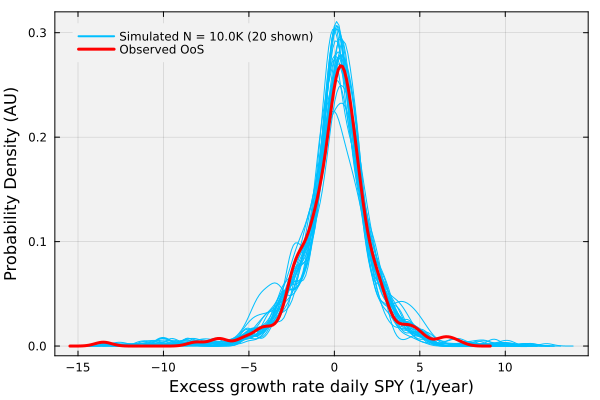

In [17]:
let
    
    # initialize
    N = 20; # how many random paths to plot
    (number_of_steps, number_of_paths) = size(market_factor_encoded_archive);
    random_index_set = rand(1:number_of_paths, N);

    q = plot(); 
    density!(out_of_sample_decoded_archive[:,1], lw=2, c=:deepskyblue1, label="Simulated N = $(number_of_paths/1000)K ($(N) shown)", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topleft)
    for i ∈ random_index_set
        density!(out_of_sample_decoded_archive[:,i], lw=1, c=:deepskyblue1, label="")
    end
    density!(Rᵢ, c=:red, lw=3, label="Observed OoS")
    xlabel!("Excess growth rate daily $(myticker) (1/year)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
    current()
end

### Trajectory
In lecture we looked at several statistical properties of the simulated excess growth rate data. Let's now look at a expected simulated trajectory for SPY versus the observed out-of-sample trajectory.

Let's start by computing the simulated price array for SPY using the decoded excess growth rates. We'll store the results in the `simulated_price_archive::Array{Float64,2}` variable, where each row corresponds to a time step and each column corresponds to a synthetic path.

In [18]:
simulated_price_archive = let

    # initialize -
    Sₒ = dataset[myticker][!, :open][1]; # initial *open* price for SPY
    (number_of_steps, number_of_paths) = size(market_factor_encoded_archive);
    simulated_price_archive = Array{Float64,2}(undef, number_of_steps, number_of_paths);
    simulated_price_archive[1,:] .= Sₒ; # set initial prices

    # populate the simulated price archive
    for i ∈ 1:number_of_paths
        for j ∈ 2:number_of_steps
            g = out_of_sample_decoded_archive[j-1,i]; # decoded excess growth rate
            S_prev = simulated_price_archive[j-1,i];
            S_new = S_prev * exp(g * Δt);
            simulated_price_archive[j,i] = S_new;
        end
    end
    simulated_price_archive; # return
end

438×10000 Matrix{Float64}:
 587.53   587.53   587.53    587.53   …  587.53   587.53   587.53   587.53
 589.84   587.771  583.487   587.176     590.451  583.221  588.273  594.389
 593.971  586.759  578.35    586.745     601.184  592.335  591.885  599.222
 593.987  586.398  578.929   585.796     604.907  597.199  592.633  597.575
 597.075  582.048  587.34    585.236     607.112  604.643  600.518  590.616
 597.305  591.486  589.664   586.424  …  614.136  606.385  600.593  586.498
 598.194  593.183  590.497   588.666     617.548  607.15   600.517  587.3
 600.873  589.71   588.938   586.716     635.437  609.382  606.895  595.752
 600.623  585.534  583.98    587.668     636.577  612.39   599.966  599.379
 602.815  589.634  581.223   576.42      636.338  614.958  607.141  602.065
   ⋮                                  ⋱                             
 712.092  749.208  435.028  1033.82      709.776  619.504  771.213  737.26
 716.38   748.022  434.832  1042.59   …  701.24   614.897  770.033  741.

Now, we can compute the mean and uncertainty bands for the simulated price trajectories. We'll use these to visualize the expected trajectory and uncertainty around it. We'll then compare the simulated trajectory to the observed out-of-sample trajectory for SPY.

In [20]:
mean_simulated_SPY_price, std_simulated_SPY_price = let

    # compute the mean and uncertainty bands
    (number_of_steps, number_of_paths) = size(simulated_price_archive);
    mean_simulated_price = Array{Float64,1}(undef, number_of_steps);
    standard_deviation_simulated_price = Array{Float64,1}(undef, number_of_steps);

    for i ∈ 1:number_of_steps
        mean_simulated_price[i] = mean(simulated_price_archive[i,:]);
        standard_deviation_simulated_price[i] = std(simulated_price_archive[i,:]);
    end

    mean_simulated_price, standard_deviation_simulated_price;
end;

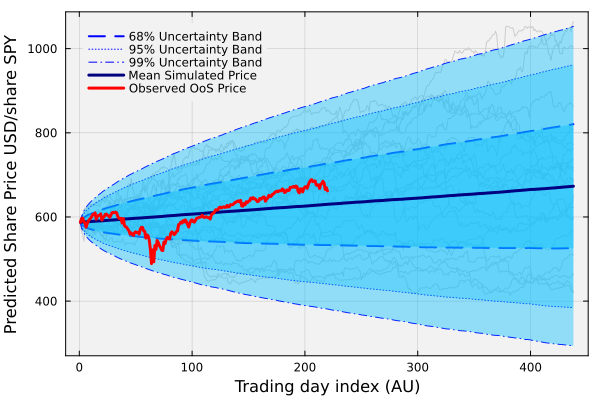

In [30]:
let

    S = dataset[myticker][!, :open]; # observed SPY prices
    UB68 = mean_simulated_SPY_price .+ 1.00 .* std_simulated_SPY_price; # upper band
    LB68 = mean_simulated_SPY_price .- 1.00 .* std_simulated_SPY_price; # lower band
    UB95 = mean_simulated_SPY_price .+ 1.96 .* std_simulated_SPY_price; # upper band
    LB95 = mean_simulated_SPY_price .- 1.96 .* std_simulated_SPY_price; # lower band
    U99 = mean_simulated_SPY_price .+ 2.576 .* std_simulated_SPY_price; # upper band
    L99 = mean_simulated_SPY_price .- 2.576 .* std_simulated_SPY_price; # lower band

    # trajectory plots    
    plot(simulated_price_archive[:,1:20], label="", c=:gray80);
    
    # 1 sd 68% uncertainty band
    plot!(UB68, lw=2, ls=:dash, c=:blue, label="68% Uncertainty Band");
    plot!(LB68, lw=2, ls=:dash, c=:blue, label="")
    plot!(mean_simulated_SPY_price, fillrange=(LB68, UB68), fillalpha=0.4, c=:deepskyblue, label="")

    # 1.96 sd 95% uncertainty band
    plot!(UB95, lw=1, ls=:dot, c=:blue, label="95% Uncertainty Band");
    plot!(LB95, lw=1, ls=:dot, c=:blue, label="")
    plot!(mean_simulated_SPY_price, fillrange=(LB95, UB95), fillalpha=0.3, c=:deepskyblue, label="")

    # 2.576 sd 99% uncertainty band
    plot!(U99, lw=1, ls=:dashdot, c=:blue, label="99% Uncertainty Band");
    plot!(L99, lw=1, ls=:dashdot, c=:blue, label="")
    plot!(mean_simulated_SPY_price, fillrange=(L99, U99), fillalpha=0.4, c=:deepskyblue, label="")
    
    # mean simulated price
    plot!(mean_simulated_SPY_price, lw=3, c=:navy, label="Mean Simulated Price", legend=:topleft)
    plot!(S, lw=3, c=:red, label="Observed OoS Price")
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    xlabel!("Trading day index (AU)", fontsize=18)
    ylabel!("Predicted Share Price USD/share $(myticker)", fontsize=18)

end

## Task 2: Let's Extend the HMM Simulation to Multiple Assets
In this task, we will extend our synthetic data generation system to handle multiple assets. We'll generate synthetic growth rate trajectories for a list of tickers using the SPY HMM model as a market factor in combination with the single index model for each asset. We can then compare the simulated trajectories to the observed out-of-sample trajectories for each asset.

Let's start by specifying a list of tickers for which we want to generate synthetic data. These tickers must be included in the `list_of_tickers::Array{String,1}` variable defined earlier, i.e., we have price and single index model parameters for these tickers. Let's store these tickers in the `my_tickers_to_simulate::Array{String,1}` variable:

In [41]:
my_tickers_to_simulate = ["AAPL", "MSFT", "MU", "NVDA", "AMD", "PG", "COST", "TGT", "LLY", "PFE", "MRK", "JNJ", "GS", "JPM", "BAC", "WFC", "C", 
    "BA", "GM", "F", "T", "UPS"]; # list of tickers to simulate

Let's check that all the tickers in `my_tickers_to_simulate` are included in `list_of_tickers`:

In [43]:
let
    
    # check that all tickers are in our dataset
    for ticker ∈ my_tickers_to_simulate
        if !(ticker ∈ list_of_tickers)
            error("Ticker $ticker is not in the dataset.")
        end
    end
    println("All $(length(my_tickers_to_simulate)) tickers are valid and present in the dataset.")
end;

All 22 tickers are valid and present in the dataset.


If we get here (without an error), all tickers are valid! Nice. Now, we can proceed to generate synthetic growth rate trajectories for each ticker in `my_tickers_to_simulate` using the SPY HMM model and the single index model parameters.

## Task 3: Let's Build a Restart Trigger
In this task, we will implement a restart trigger mechanism for our synthetic data generation system. The restart trigger will allow us to reset the simulation under certain conditions, such as when the simulated price deviates significantly from the observed price.

## Summary
One direct summary sentence goes here.

> __Key Takeaways:__
> 
> Three key takeaways go here.

One direct concluding sentence goes here.
___

## Tests
The code block below shows how we implemented the tests and what we are testing. In these tests, we check values in your notebook and give feedback on which items are correct, missing, etc.

In [22]:
@testset verbose = true "CHEME 5800 PS6 Test Suite" begin
end;

Test Summary:             | Total  Time
CHEME 5800 PS6 Test Suite |     0  0.1s


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses should be used.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.

___